In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from made import MADE
from data.toydata import ToyDataset

from train import train_forward
from scores import log_likelihood
from scores import difference_loglik

from utils import update_device

In [3]:
from flows import create_iaf
from flows import create_maf
from flows import create_paf
from flows import create_realnvp
from flows import create_flows

In [4]:
from structure.ar import AR
from structure.iar import IAR
from structure.twoblock import TwoBlock

from transforms.affine import Affine
from transforms.piecewise import PiecewiseAffine

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device_cpu = torch.device("cpu")

In [6]:
dataset = ToyDataset()

In [7]:
dim_input = 2
dim_hidden = [10,10,10]
num_trans = 8
perm_type = 'alternate'

epochs = 10
batch_size = 10

In [11]:
flows, names = [], []
#flows.append(create_iaf(dim_input, dim_hidden, num_trans, perm_type)), names.append('IAF')
flows.append(create_maf(dim_input, dim_hidden, num_trans, perm_type)),names.append('MAF')
flows.append(create_paf(dim_input, dim_hidden, num_trans, perm_type)), names.append('PAF')
#flows.append(create_realnvp(dim_input, dim_hidden, num_trans, perm_type)), names.append('Real NVP')

#transformations = [Affine, Affine, PiecewiseAffine, PiecewiseAffine, Affine, Affine, PiecewiseAffine, PiecewiseAffine]
#structures = IAR
#flows.append(create_flows(dim_input, dim_hidden, num_trans, perm_type, structure=structures, transformation=transformations)), names.append(PAF/IAF)

(None, None)

In [12]:
losses = []
for flow in flows:
    update_device(device, flow, dataset)

    #optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3)
    optimizer = torch.optim.SGD(flow.parameters(), lr=1e-3)

    losses.append(train_forward(flow, flow.get_base_distr(), dataset.get_training_data(), optimizer, epochs, batch_size,print_n=10))

update_device(device_cpu, flow, dataset)

     4.27619


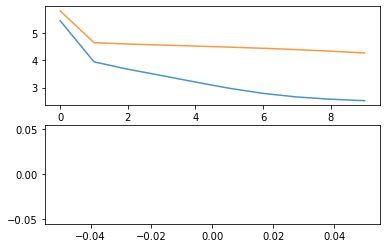

In [13]:
plt.subplot(2,1,1)
for i in range(len(losses)):
    plt.plot(losses[i], label=names[i], alpha=0.8)

plt.subplot(2,1,2)
for i in range(len(losses)):
    plt.plot((losses[i])[20:], label=names[i], alpha=0.8)


In [14]:
train_data = dataset.get_training_data()

In [22]:
print('Results based on training data:' + '\n')
for i in range(len(flows)):
    log_lik, mean = log_likelihood(train_data, flows[i])
    print("Mean loglikelihood for " + names[i] + ":" + str(mean))
    
    log_lik_diff, mean_diff = difference_loglik(train_data, dataset, flows[i])
    print("Mean difference from target loglikelihood for " + names[i] + ":" + str(mean_diff) + '\n')
    

Results based on training data:

Mean loglikelihood for MAF:[-2.4983926]
Mean difference from target loglikelihood for MAF:[0.38353616]

Mean loglikelihood for PAF:[-4.2379127]
Mean difference from target loglikelihood for PAF:[1.9588124]



In [26]:
print('Results based on new sample from each flow:' + '\n')

for i in range(len(flows)):
    with torch.no_grad():
        sample, log_prob = flow.sample(800)
        sample_last = sample[-1]
        
    log_lik, mean = log_likelihood(sample_last, flows[i])
    print("Mean loglikelihood for " + names[i] + ":" + str(mean))
    
    log_lik_diff, mean_diff = difference_loglik(sample_last, dataset, flows[i])
    print("Mean difference from target loglikelihood for " + names[i] + ":" + str(mean_diff) + '\n')

    

Results based on new sample from each flow:

Mean loglikelihood for MAF:[-15.743261]
Mean difference from target loglikelihood for MAF:[9.948595]

Mean loglikelihood for PAF:[-3.9002285]
Mean difference from target loglikelihood for PAF:[20.971136]

